# 戦略・銘柄毎のシグナル判定（オシレーター・日足）

In [2]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import talib
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## ta-libにない関数の定義

In [4]:
# function Elder's Force Index (EFI)
def elder_force_index(df, period=2):
    df['EFI'] = (df['Close'] - df['Close'].shift(1)) * df['Volume']
    df['EFI_Smoothed'] = df['EFI'].rolling(window=period).mean()
    return df['EFI_Smoothed']

# function true_strength_index (TSI)
def true_strength_index(df, short_period=13, long_period=25):
    df['Change'] = df['Close'] - df['Close'].shift(1)
    df['Smoothed1'] = df['Change'].ewm(span=short_period, adjust=False).mean()
    df['Smoothed2'] = df['Smoothed1'].ewm(span=long_period, adjust=False).mean()
    df['AbsChange'] = abs(df['Change'])
    df['AbsSmoothed1'] = df['AbsChange'].ewm(span=short_period, adjust=False).mean()
    df['AbsSmoothed2'] = df['AbsSmoothed1'].ewm(span=long_period, adjust=False).mean()
    df['TSI'] = (df['Smoothed2'] / df['AbsSmoothed2']) * 100
    return df['TSI']

# オーサムオシレーター
def awesome_oscillator(df, wshort=5, wlong=34):
  # 中値
  df['med'] = (df['High']+df['Low']) / 2
  # オーサムオシレーター
  df['ao'] = df['med'].rolling(wshort).mean() - df['med'].rolling(wlong).mean()
  # 加速減速オシレーター
  df['ado'] = df['ao'] - df['ao'].rolling(wshort).mean()
  return df['ao'], df['ado']

## シグナル検出用関数

In [6]:
# クロスオーバーとクロスアンダー及びしきい値クロス関数
def crossover(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def overthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def crossunder(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

def underthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

## パフォーマンス評価（バックテスト）

In [8]:
def evaluate_performance(data):
    cumulative_return = data['Portfolio_Value'].iloc[-1] / data['Portfolio_Value'].iloc[0] - 1
    volatility = data['Daily_Return'].std() * (252**0.5)
    sharpe_ratio = (data['Daily_Return'].mean() / data['Daily_Return'].std()) * (252**0.5)
    return {
        "Cumulative Return": cumulative_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

## 指標別のシグナル判定とポジション判定

In [10]:
# Chande Momentum Oscillator (CMO)ゼロクロスによるシグナル判定とポジション判定
def CMO_zero(df, tp=14):
    # create dataframe
    df1 = df.copy()
    # calculate CMO
    df1['CMO'] = talib.CMO(df['Close'], timeperiod=tp)
    # BUY/SELL signal conditions
    df1['CMO_buySignal'] = overthreshold(df1['CMO'], 0)
    df1['CMO_sellSignal'] = underthreshold(df1['CMO'], 0)
    # position
    df1['CMO_Position'] = [1 if x >= 0 else -1 for x in df1['CMO']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','CMO_buySignal','CMO_sellSignal','CMO_Position']]

In [11]:
# Elder's Force Index (EFI)ゼロクロスによるシグナル判定とポジション判定
def EFI_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate EFI
    df1['EFI'] = elder_force_index(df)
    # BUY/SELL signal conditions
    df1['EFI_buySignal'] = overthreshold(df1['EFI'], 0)
    df1['EFI_sellSignal'] = underthreshold(df1['EFI'], 0)
    # position
    df1['EFI_Position'] = [1 if x >= 0 else -1 for x in df1['EFI']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','EFI_buySignal','EFI_sellSignal','EFI_Position']]

In [12]:
# True Strength Index (TSI)ゼロクロスによるシグナル判定とポジション判定
def TSI_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate TSI
    df1['TSI'] = true_strength_index(df)
    # BUY/SELL signal conditions
    df1['TSI_buySignal'] = overthreshold(df1['TSI'], 0)
    df1['TSI_sellSignal'] = underthreshold(df1['TSI'], 0)
    # position
    df1['TSI_Position'] = [1 if x >= 0 else -1 for x in df1['TSI']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','TSI_buySignal','TSI_sellSignal','TSI_Position']]

In [13]:
# Aroon Oscillator (ARO)ゼロクロスによるシグナル判定とポジション判定
def ARO_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate ARO
    df1['ARO'] = talib.AROONOSC(df['High'], df['Low'], timeperiod=25)
    # BUY/SELL signal conditions
    df1['ARO_buySignal'] = overthreshold(df1['ARO'], 0)
    df1['ARO_sellSignal'] = underthreshold(df1['ARO'], 0)
    # position
    df1['ARO_Position'] = [1 if x >= 0 else -1 for x in df1['ARO']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','ARO_buySignal','ARO_sellSignal','ARO_Position']]

In [14]:
# Awesome Oscillator (AO)ゼロクロスによるシグナル判定とポジション判定
def AO_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate AO
    df1['AO'], df1['ADO'] = awesome_oscillator(df)
    # BUY/SELL signal conditions
    df1['AO_buySignal'] = overthreshold(df1['AO'], 0)
    df1['AO_sellSignal'] = underthreshold(df1['AO'], 0)
    # position
    df1['AO_Position'] = [1 if x >= 0 else -1 for x in df1['AO']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','AO_buySignal','AO_sellSignal','AO_Position']]

In [15]:
# TRIX Oscillator (TRIX)ゼロクロスによるシグナル判定とポジション判定
def TRIX_zero(df):
    # create dataframe
    df1 = df.copy()
    # calculate TRIX
    df1['TRIX'] = talib.TRIX(df['Close'], timeperiod=9)
    # BUY/SELL signal conditions
    df1['TRIX_buySignal'] = overthreshold(df1['TRIX'], 0)
    df1['TRIX_sellSignal'] = underthreshold(df1['TRIX'], 0)
    # position
    df1['TRIX_Position'] = [1 if x >= 0 else -1 for x in df1['TRIX']]
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','TRIX_buySignal','TRIX_sellSignal','TRIX_Position']]

In [16]:
# 評価する銘柄のリスト
list_ticker = ['7011.T','8306.T','5803.T']
# 期間の指定
end_date = datetime.today()
start_date = end_date - timedelta(days=730)

In [17]:
# 各銘柄についてシグナル判定を行い結果を縦連結する
df0 = pd.DataFrame()
for symbol in list_ticker:
    # yahooサイトからデータをダウンロード
    data = yf.download(symbol, start_date, end_date)
#    data.columns = ['Close','High','Low','Open','Volume'] # 列名がタプルになっている場合の処理
    data['ticker'] = symbol
    df = data.reset_index().drop(columns='Close').rename(columns={'Date':'timestamp','Adj Close':'Close'})
    # リターンの計算
    df['Returns'] = df['Close'].pct_change()
#    df = data.reset_index().rename(columns={'Date':'timestamp'}) # 列名がタプルになっている場合の処理
    ## Chande Momentum Oscillator (CMO)ゼロクロスによるシグナル判定の実施
    df_CmoZero = CMO_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_CmoZero, how="inner", on=['timestamp','ticker'])
    ## Elder's Force Index (EFI)ゼロクロスによるシグナル判定の実施
    df_EfiZero = EFI_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_EfiZero, how="inner", on=['timestamp','ticker'])
    ## True Strength Index (TSI)ゼロクロスによるシグナル判定の実施
    df_TsiZero = TSI_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_TsiZero, how="inner", on=['timestamp','ticker'])
    ## Aroon oscillator (ARO)ゼロクロスによるシグナル判定の実施
    df_AroZero = ARO_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_AroZero, how="inner", on=['timestamp','ticker'])
    ## Awesome oscillator (AO)ゼロクロスによるシグナル判定の実施
    df_AoZero = AO_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_AoZero, how="inner", on=['timestamp','ticker'])
    ## TRIX oscillator (TRIX)ゼロクロスによるシグナル判定の実施
    df_TrixZero = TRIX_zero(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_TrixZero, how="inner", on=['timestamp','ticker'])
    # 一銘柄のシグナル判定結果を元のデータに縦連結する
    df0 = pd.concat([df0,df],axis=0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## チャートによるシグナルの検証及びパフォーマンス評価

In [19]:
print(list_ticker)

['7011.T', '8306.T', '5803.T']


In [20]:
# 銘柄の指定（list_tickerにある銘柄のみ）
focus_ticker = '5803.T'
# 特定の銘柄のデータを取り出す
df = df0[df0['ticker'].str.contains(focus_ticker)]

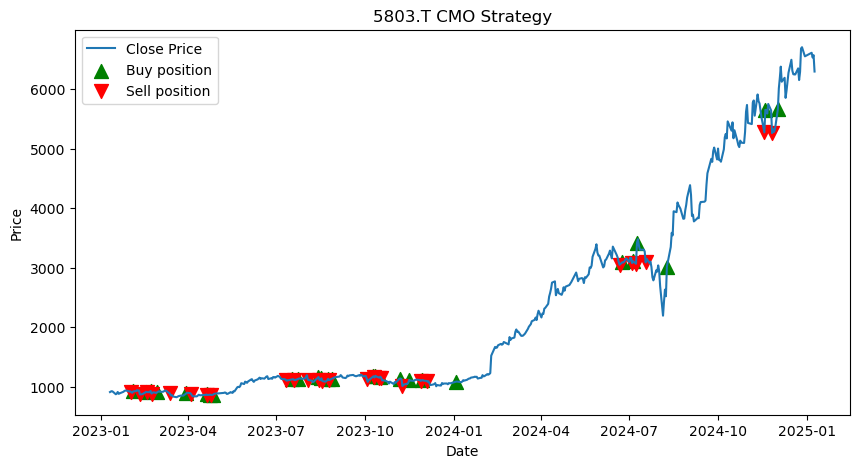

In [21]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['CMO_buySignal']], df['Close'][df['CMO_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['CMO_sellSignal']], df['Close'][df['CMO_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' CMO Strategy')
# チャートの表示
plt.show()

In [22]:
# バックテスト
# その日のポジションの符号と株価の変化率を乗じてリターンとする
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data['CMO_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print('CMO Performance')
print(performance)

CMO Performance
{'Cumulative Return': 0.4850349242295049, 'Volatility': 0.5162425794668952, 'Sharpe Ratio': 0.6486642266741091}


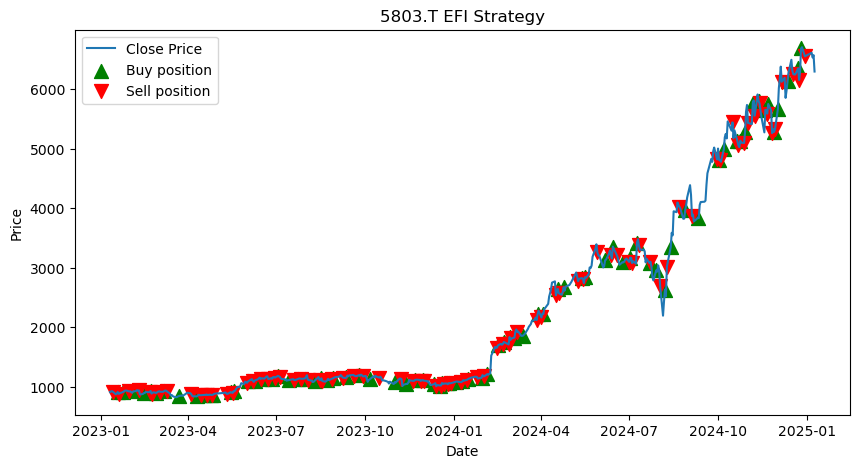

In [23]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['EFI_buySignal']], df['Close'][df['EFI_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['EFI_sellSignal']], df['Close'][df['EFI_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' EFI Strategy')
# チャートの表示
plt.show()

In [24]:
# バックテスト
# その日のポジションの符号と株価の変化率を乗じてリターンとする
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data['EFI_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print('EFI Performance')
print(performance)

EFI Performance
{'Cumulative Return': 1.0142211326933928, 'Volatility': 0.5157534403416036, 'Sharpe Ratio': 0.9480551945774092}


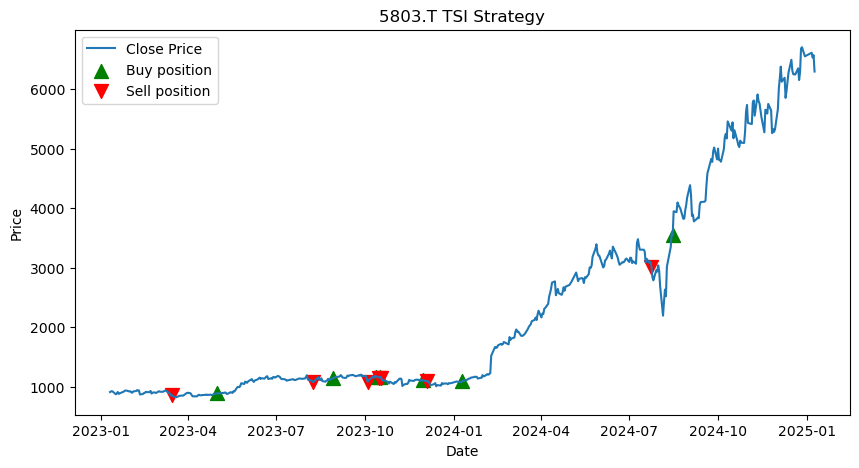

In [25]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['TSI_buySignal']], df['Close'][df['TSI_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['TSI_sellSignal']], df['Close'][df['TSI_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' TSI Strategy')
# チャートの表示
plt.show()

In [26]:
# バックテスト
# その日のポジションの符号と株価の変化率を乗じてリターンとする
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data['TSI_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print('TSI Performance')
print(performance)

TSI Performance
{'Cumulative Return': 2.083631443980955, 'Volatility': 0.5147341439423435, 'Sharpe Ratio': 1.3781747417969188}


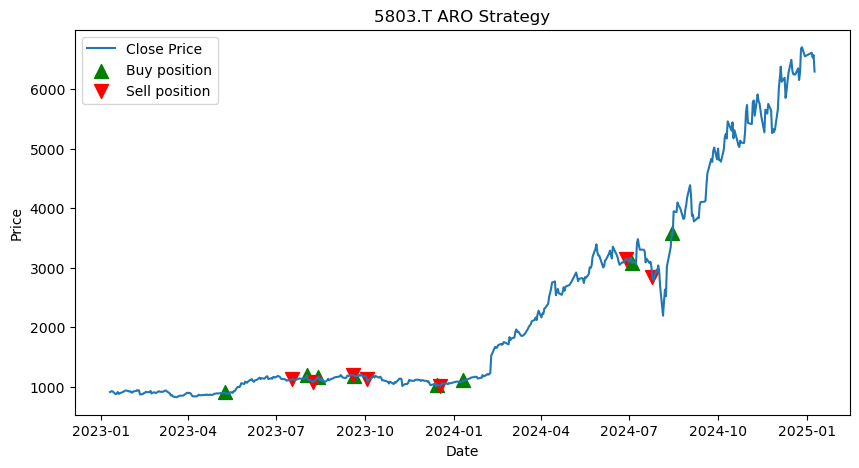

In [27]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['ARO_buySignal']], df['Close'][df['ARO_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['ARO_sellSignal']], df['Close'][df['ARO_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' ARO Strategy')
# チャートの表示
plt.show()

In [28]:
# バックテスト
# その日のポジションの符号と株価の変化率を乗じてリターンとする
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data['ARO_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print('ARO Performance')
print(performance)

ARO Performance
{'Cumulative Return': 2.060108112278001, 'Volatility': 0.5147564540147825, 'Sharpe Ratio': 1.3701832234577533}


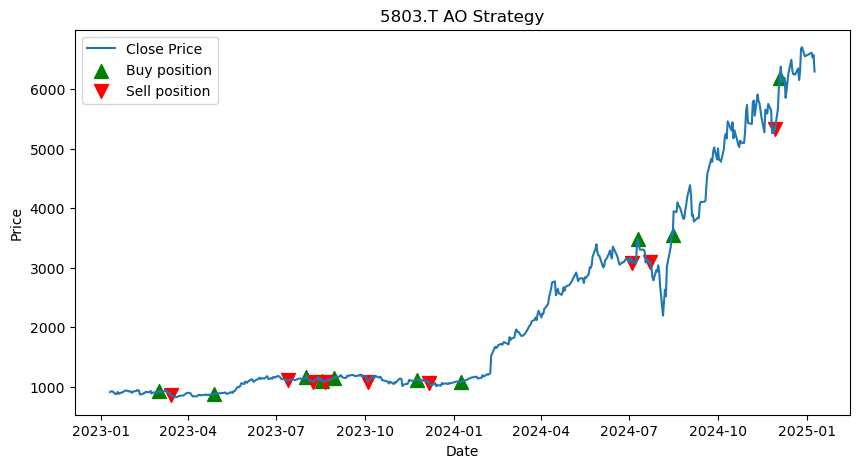

In [29]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['AO_buySignal']], df['Close'][df['AO_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['AO_sellSignal']], df['Close'][df['AO_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' AO Strategy')
# チャートの表示
plt.show()

In [30]:
# バックテスト
# その日のポジションの符号と株価の変化率を乗じてリターンとする
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data['AO_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print('AO Performance')
print(performance)

AO Performance
{'Cumulative Return': 0.5683951049555052, 'Volatility': 0.5161671501253975, 'Sharpe Ratio': 0.7031322380687041}


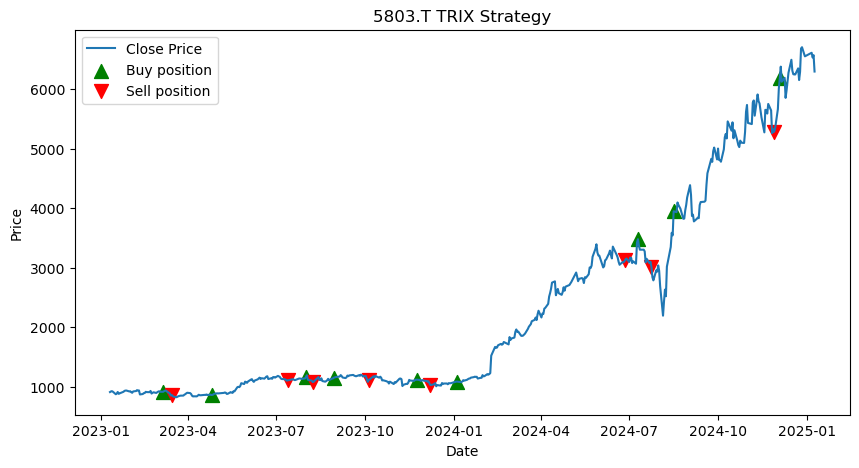

In [31]:
# 終値と各種指標のプロット
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['Close'], label='Close Price')
# 売買ポジションのプロット
plt.scatter(df['timestamp'][df['TRIX_buySignal']], df['Close'][df['TRIX_buySignal']], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['TRIX_sellSignal']], df['Close'][df['TRIX_sellSignal']], color='red', label='Sell position', marker="v", s=100)
# 凡例の表示
plt.legend()
# 軸ラベルとタイトル
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(focus_ticker + ' TRIX Strategy')
# チャートの表示
plt.show()

In [32]:
# バックテスト
# その日のポジションの符号と株価の変化率を乗じてリターンとする
initial_balance = 10000
data = df.copy()
data['Daily_Return'] = data['Returns'] * data['TRIX_Position'].shift()
data['Portfolio_Value'] = (1 + data['Daily_Return']).cumprod() * initial_balance
data.at[data.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(data)
print('TRIX Performance')
print(performance)

TRIX Performance
{'Cumulative Return': 0.3084391133539637, 'Volatility': 0.5163927565514546, 'Sharpe Ratio': 0.5237053951784006}
